In [1]:
import sys
sys.path.insert(1, 'C:/Users/hp/Desktop/Python Exeter Repos/Python-Exeter/DECAF/')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from decaf.DECAF import DECAF
from decaf.data import DataModule
from typing import Tuple
import networkx as nx
import numpy as np
import pytorch_lightning as pl
import torch
import pandas as pd
import cdt
import argparse
from pgmpy.estimators import PC
cdt.SETTINGS.rpath = "C:/Program Files/R/R-4.3.0/bin/Rscript.exe" # path to your r executable

Detecting 1 CUDA device(s).


In [7]:
data = load_iris(return_X_y=False)
dataframe_X = pd.DataFrame(data=data['data'],columns=data['feature_names'])
dataframe_Y = pd.DataFrame(data=data['target'],columns=['target'])

In [3]:
columns_dict = {i:dataframe_X.columns[i] for i in range(len(dataframe_X.columns))}
dataframe_X.columns = [i for i in range(len(dataframe_X.columns))]
columns_dict

{0: 'sepal length (cm)',
 1: 'sepal width (cm)',
 2: 'petal length (cm)',
 3: 'petal width (cm)'}

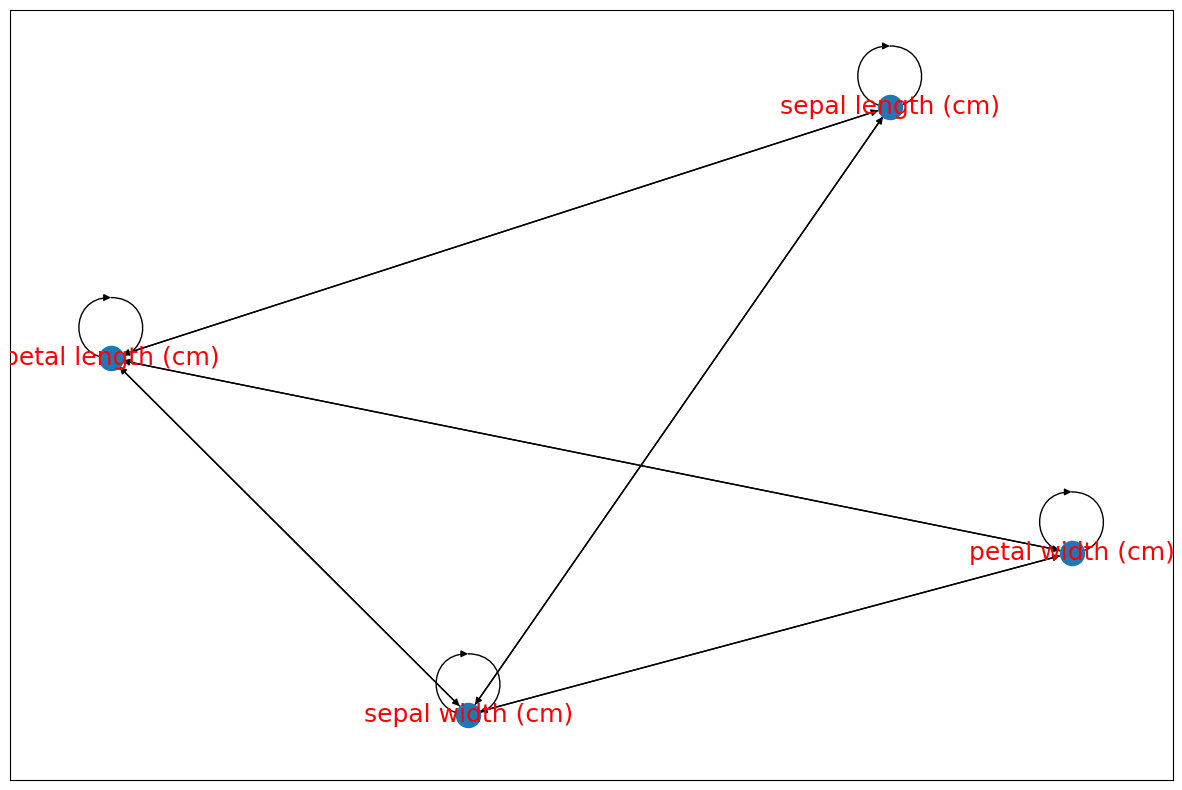

In [13]:
# Get skeleton graph
# initialize graph lasso
glasso = cdt.independence.graph.Glasso()
# apply graph lasso to data
skeleton = glasso.predict(dataframe_X)
# visualize network
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')


PC is ran on the skeleton of the given graph.


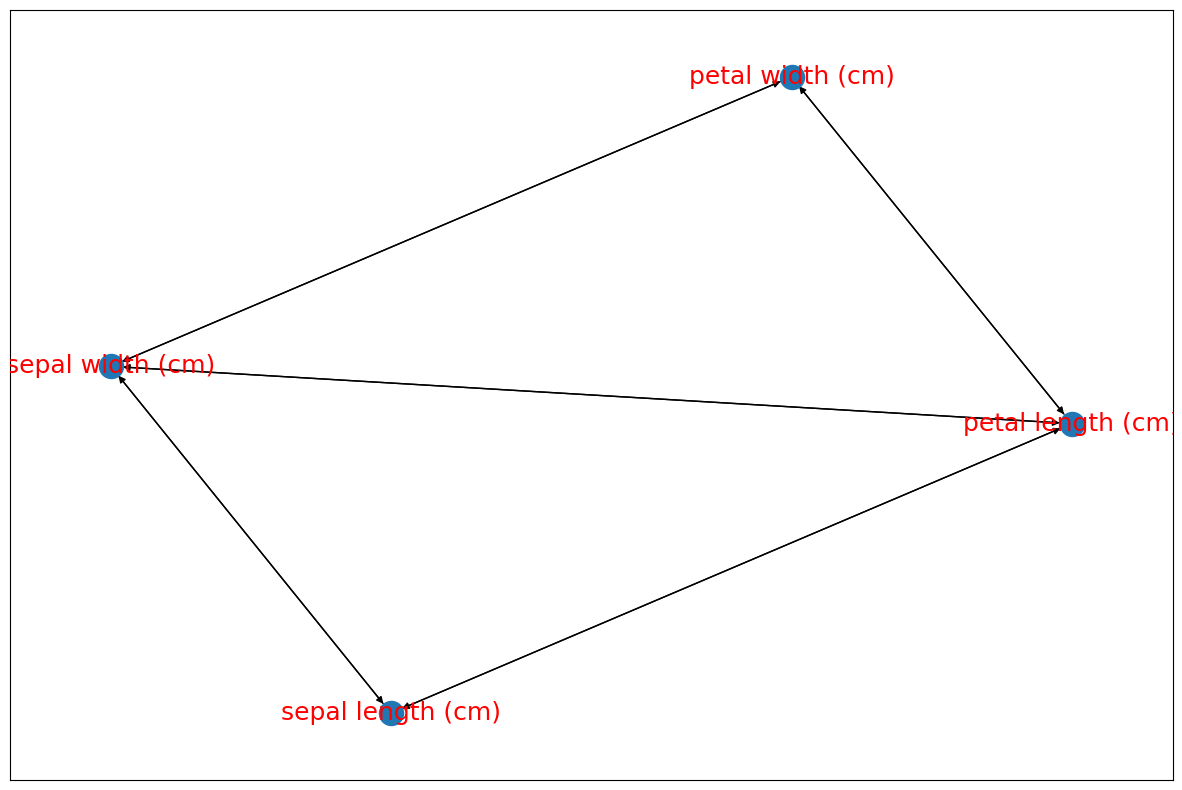

In [14]:
# Use causal discovery to get causal models
# PC algorithm
model_pc = cdt.causality.graph.PC()
graph_pc = model_pc.predict(dataframe_X, skeleton)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc, font_size=18, font_color='r')

In [6]:
nx.is_directed_acyclic_graph(graph_pc)

False

In [6]:
seed = [list(i) for i in graph_pc.edges]
seed

[[0, 1], [0, 2], [2, 0], [2, 1], [2, 3], [3, 1], [3, 2]]

In [7]:
dm = DataModule(np.array(data['data']))
data_tensor = dm.dataset.x

2023-05-18 16:12:54.823 | INFO     | decaf.logger:log_and_print:64 - ***** DATA ****
2023-05-18 16:12:54.824 | INFO     | decaf.logger:log_and_print:64 - n_samples = 150


In [8]:
x_dim = dm.dims[0]
z_dim = x_dim  # noise dimension for generator input. For the causal system, this should be equal to x_dim
lambda_privacy = 0  # privacy used for ADS-GAN, not sure if necessary for us tbh
lambda_gp = 10  # gradient penalisation used in WGAN-GP
l1_g = 0  # l1 reg on sum of all parameters in generator
weight_decay = 1e-2 
grad_dag_loss = False
number_of_gpus = 0

In [9]:
model = DECAF(
    dm.dims[0],
    dag_seed=seed,
    h_dim=200,
    lr=0.5e-3,
    batch_size=64,
    lambda_privacy=0,
    lambda_gp=lambda_gp,
    alpha=2,
    rho=2,
    weight_decay=weight_decay,
    grad_dag_loss=grad_dag_loss,
    l1_g=l1_g,
    l1_W=1e-4,
)
trainer = pl.Trainer(
    max_epochs=10,
    profiler=False,
    callbacks=[],
)
trainer.fit(model, dm)
synth_data = (
    model.gen_synthetic(data_tensor).detach().cpu().numpy()
)
print("Data generated successfully!")


2023-05-18 16:12:59.500 | INFO     | decaf.logger:log_and_print:64 - dag_seed [[0, 1], [0, 2], [2, 0], [2, 1], [2, 3], [3, 1], [3, 2]]
2023-05-18 16:12:59.502 | INFO     | decaf.logger:log_and_print:64 - Setting up network with x_dim = 4, z_dim = 4, h_dim = 200
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name          | Type             | Params
---------------------------------------------------
0 |

Training: 0it [00:00, ?it/s]

NetworkXUnfeasible: Graph contains a cycle or graph changed during iteration